# CPSC222 - DA7 Titanic Classification

Jonathan Smoley

December 9, 2021

In [124]:
# imported libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
import scipy.stats as stats

## Data Collection/Cleaning/Preparation

The titanic dataset holds data for 889 passengers (instances) and 11 different attributes. Of those attributes, many can be encoded to fit continuous data such that they can be used in classification. However, the names, tickets, and cabins of each passenger are distinct and those columns will have to be removed. That leaves the attributes of survival binary, class, sex, age, number of siblings/spouses, number of parents/children, ticket fare, and point embarked from.

In [125]:
# data collection
titanic_df = pd.read_csv('titanic.csv', index_col = 'PassengerId')

# data cleaning
titanic_df.drop(['Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)
sex_values = titanic_df.groupby('Sex').groups
titanic_df['Sex'] = LabelEncoder().fit_transform(titanic_df['Sex'])
titanic_df.dropna(subset = ['Embarked'], inplace = True)
embarked_values = titanic_df.groupby('Embarked').groups
titanic_df['Embarked'] = LabelEncoder().fit_transform(titanic_df['Embarked'])
age_values = titanic_df.groupby('Age').groups

## Exploratory Data Analysis

I would like to discover which attributes may have determined whether a passenger survived or did not survive. To do this, I follow the steps below:

1. Group by "Survived"
    * first I want to group the remaining features by whether or not the passenger survived.
    * to do so I can use the `get_group()` and `describe()` functions
    * the last task for this step is to compute summary stats on the dataset
2. Visualize Related Features
    * here I want to choose at least two different features to display in a plot based on summary data & relatedness to the "Survive" feature
3. Apply t-tests on two of the features predicted to be related to the "Survived" feature
    * the desired features are to be used in distinguishing between those who survived and those who did not
4. Store in Separate Series Objects
    * simply load the set of passengers that survived and those that did not survive into their respective pandas Series objects
5. Train a Decision Tree Classifier
    * the tree should have a depth of 3
    * the tree should be visualized with `sklearn.tree.plot_tree`

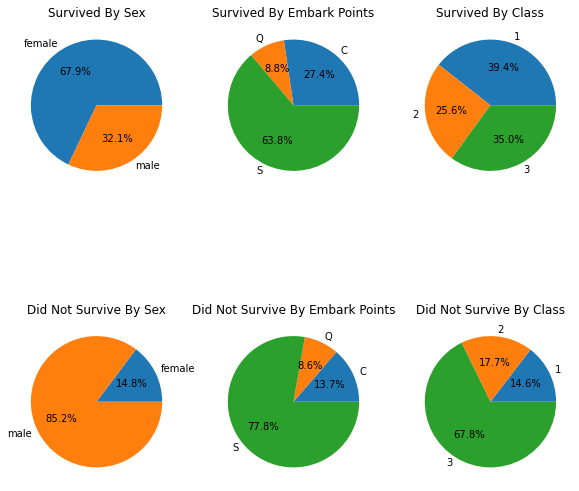

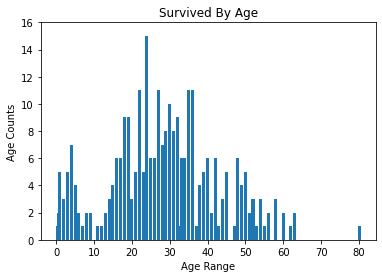

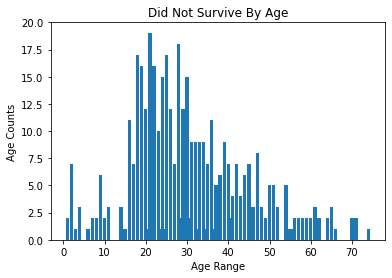

In [126]:
# grouping/stats
grouped_by_survived = titanic_df.groupby('Survived')
died_stats = grouped_by_survived.get_group(0).describe()
survived_stats = grouped_by_survived.get_group(1).describe()

# visualization
figs, axs = plt.subplots(2, 3, figsize = (10, 10))

axs[0, 0].pie(grouped_by_survived.get_group(1)['Sex'].value_counts().sort_index(), 
    labels = sex_values.keys(), autopct = '%1.1f%%')
axs[0, 0].set_title('Survived By Sex')

axs[1, 0].pie(grouped_by_survived.get_group(0)['Sex'].value_counts().sort_index(), 
    labels = sex_values.keys(), autopct = '%1.1f%%')
axs[1, 0].set_title('Did Not Survive By Sex')

axs[0, 1].pie(grouped_by_survived.get_group(1)['Embarked'].value_counts().sort_index(), 
    labels = embarked_values.keys(), autopct = '%1.1f%%')
axs[0, 1].set_title('Survived By Embark Points')

axs[1, 1].pie(grouped_by_survived.get_group(0)['Embarked'].value_counts().sort_index(), 
    labels = embarked_values.keys(), autopct = '%1.1f%%')
axs[1, 1].set_title('Did Not Survive By Embark Points')

axs[0, 2].pie(grouped_by_survived.get_group(1)['Pclass'].value_counts().sort_index(),
    labels = titanic_df.groupby('Pclass').groups.keys(), autopct = '%1.1f%%')
axs[0, 2].set_title('Survived By Class')

axs[1, 2].pie(grouped_by_survived.get_group(0)['Pclass'].value_counts().sort_index(),
    labels = titanic_df.groupby('Pclass').groups.keys(), autopct = '%1.1f%%')
axs[1, 2].set_title('Did Not Survive By Class')

plt.show()

plt.figure()
plt.bar(grouped_by_survived.get_group(1)['Age'].value_counts(dropna = True).sort_index().index, grouped_by_survived.get_group(1)['Age'].value_counts(dropna = True).sort_index())
plt.xticks(range(0, int(grouped_by_survived.get_group(1)['Age'].max() + 1), 10))
plt.xlabel('Age Range')
plt.ylim(0, 16)
plt.ylabel('Age Counts')
plt.title('Survived By Age')
plt.show()

plt.figure()
plt.bar(grouped_by_survived.get_group(0)['Age'].value_counts(dropna = True).sort_index().index, grouped_by_survived.get_group(0)['Age'].value_counts(dropna = True).sort_index())
plt.xticks(range(0, int(grouped_by_survived.get_group(0)['Age'].max() + 1), 10))
plt.xlabel('Age Range')
plt.ylim(0, 20)
plt.ylabel('Age Counts')
plt.title('Did Not Survive By Age')
plt.show()

### Visualization Findings
It appears that both sex and class are related to survival in some capacity. Also, the average age for survival seems to be lesser than the average age for not having survived. But, points of embarkment do not seem to be related to survival.

### Hypothesis Testing

With suspicions as to what attributes are related to a passenger's survival, I can perform a hypothesis test to see if my hypotheses are warranted (as they cannot be true or false w/ a t-test).

1. Test whether sex affected a passenger's survival.
    * $H_{o}$ = $\mu^{survived}_{male}$ <= $\mu^{survived}_{female}$
    * $H_{1}$ = $\mu^{survived}_{male}$ > $\mu^{survived}_{female}$
    * degrees of freedom: 549
    * level of significance: 0.05
    * t-critical: 1.6479
    * if t-comp >= t-crit, reject $H_{o}$
    * if t-comp < t-crit, do not reject $H_{o}$

2. Test whether class affected a passenger's survival.
    * $H_{o}$ = $\mu^{survived}_{1st class}$ >= $\mu^{survived}_{3rd class}$
    * $H_{1}$ = $\mu^{survived}_{1st class}$ < $\mu^{survived}_{3rd class}$
    * degrees of freedom: 549
    * level of significance: 0.05
    * t-critical: 1.6479
    * if t-comp <= t-crit, reject $H_{o}$
    * if t-comp > t-crit, do not reject $H_{o}$

In [127]:
# t-testing
t, p = stats.ttest_ind(grouped_by_survived.get_group(1).groupby('Sex').get_group(0), 
    grouped_by_survived.get_group(1).groupby('Sex').get_group(1))
print('t-statistic:', t[4], 'p-statistic:', p[4]/2)

t, p = stats.ttest_ind(grouped_by_survived.get_group(1).groupby('Pclass').get_group(3), 
    grouped_by_survived.get_group(1).groupby('Pclass').get_group(1))
print('t-statistic:', t[7], 'p-statistic:', p[7])

t-statistic: 1.6304276878588548 p-statistic: 0.051971297314769994
t-statistic: 2.099282175149379 p-statistic: 0.03679094551297144


### Decision
By the results of the hypothesis testing, more female passengers survived than male passengers and more 1st class passengers survived than 3rd class passengers. I cannot reject my hypotheses.

In [128]:
# store in Series objects
x = pd.concat([titanic_df['Pclass'], titanic_df['Sex']], axis = 1, keys = ['Pclass', 'Sex'])
y = titanic_df['Survived']

### Train Decision Tree Classifier
I want to create a decision tree classifer for this titanic data to effectively classify passenger survival status. It should not be too deep, so a depth of 3 will suffice. Afterward, I want to visualize this decision tree.

Acurracy: 0.7937219730941704


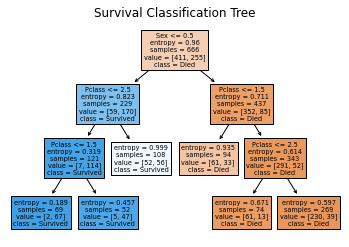

In [129]:
# decision tree classifier
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 0, stratify = y)

clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, random_state = 0).fit(x_train, y_train)

y_pred = clf.predict(x_test)

print("Acurracy:", clf.score(x_test, y_test))
# plot decision tree
plot_tree(clf, feature_names = x.columns, class_names = ['Died', 'Survived'], filled = True)
plt.title('Survival Classification Tree')
plt.show()

>How do the hypotheses compare to the decision tree output?

If the passenger's sex is less 0.5, then they died. If the passenger's class is less than 2.5, then they survive. This correlates with my hypothesis tesing where 1st class passengers were more likely to survive than 3rd class passengers and where females were more likely to survive than males.

## Build/Refine Machine Learning Models
Here I want to scale the features and evaluate the accuracy of a kNN classifer using the hold out method to divine the titanic dataset. Doing so will allow me to improve my classifier to make more accurate predictions. Finally, I want to compare these results with that of a Decision Tree Classifier.

In [130]:
# min/max scaling
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0, stratify = y)

kNN_clf = KNeighborsClassifier(n_neighbors = 250).fit(x_train, y_train)

y_pred = kNN_clf.predict(x_test)

print("Accuracy:", kNN_clf.score(x_test, y_test))

Accuracy: 0.8116591928251121


The best accuracy that can be achieved is ~81% which is reached when classifying the test set based upon either 250 or 400 of the test set's nearest neighbors. Now that I have a result, it can be compared to that of a Decision Tree Classifier.

In [131]:
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, random_state = 0).fit(x_train, y_train)

y_pred = clf.predict(x_test)

print("Acurracy:", clf.score(x_test, y_test))

Acurracy: 0.7937219730941704


## Result
The comparison between the kNN classifier and the Decision Tree classifier showed that, for this exercise, the kNN classifier is more accurate in predicting whether a passenger survived based on that passenger's sex and class.